In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

import os
import pickle
import shutil

import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

In [2]:
from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Dataset

### 0. mosaic function

In [3]:
import numpy as np


def add_mosaic(img_2d: np.ndarray, window_size=(9, 9), mode='mean'):
#     img_2d = np.arange(0, 400).reshape(20, 20)
    assert window_size[0] == window_size[1], "window_size[0] != window_size[1]"
    assert img_2d.ndim == 3, "image dimensions should be [C, H, W]"
    stride = window_size[0]
    C, H, W = img_2d.shape
    new_img_2d = np.zeros_like(img_2d)

    _H, _W = window_size

    for channel_idx in range(C):
        h_i, w_i = 0, 0
        while True:
            h_j = h_i + _H
            w_j = w_i + _W
            img_window = img_2d[channel_idx, h_i:h_j, w_i:w_j]

            if img_window.numel != 0:
                if mode=='mean':
                    fill = img_window.mean()
                elif mode == 'max':
                    fill = img_window.max()
                elif mode == 'min':
                    fill = img_window.min()

                new_img_2d[channel_idx, h_i:h_j, w_i:w_j] = fill

            w_i += stride

            if h_j >= H and w_j >= W:
                break
            if w_j >= W:
                w_i = 0
                h_i += stride
    return new_img_2d

### 1. load dataset

#### 1.1 Google Colab -- download and process data

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benlaw","key":"f4b4e6360dfb5fa4ec1d37e7fd447625"}'}

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets list

ref                                                                title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                            Most Streamed Spotify Songs 2023                 47KB  2023-08-26 11:04:57          25011        765  1.0              
nelgiriyewithana/credit-card-fraud-detection-dataset-2023          Credit Card Fraud Detection Dataset 2023        143MB  2023-09-18 10:00:19           3640        124  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset                 Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37           1558         44  1.0              
tawfikelmetwally/employee-dataset                                

In [10]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

100% 786M/788M [00:36<00:00, 23.3MB/s]
100% 788M/788M [00:36<00:00, 22.8MB/s]


In [11]:
!unzip "/content/microsoft-catsvsdogs-dataset.zip" -d "/content/dogs-vs-cats"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dogs-vs-cats/PetImages/Dog/550.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5500.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5501.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5502.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5503.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5504.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5505.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5506.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5507.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5508.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5509.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/551.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5510.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5511.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/5512.jpg  
  inflating: /content/dogs-vs-cats/PetImages/Dog/55

In [12]:
# move all to train and test folder
all_dirs = []
for main_path in ["/content/dogs-vs-cats/PetImages/Cat", "/content/dogs-vs-cats/PetImages/Dog"]:
  for dir in os.listdir(main_path):
    all_dirs.append(os.path.join(main_path, dir))

In [13]:
len(all_dirs)

25002

In [14]:
os.mkdir("/content/dogs-vs-cats/data")
os.mkdir("/content/dogs-vs-cats/data/train")
os.mkdir("/content/dogs-vs-cats/data/test")

In [15]:
# shutil.rmtree("/content/dogs-vs-cats/data")

In [16]:
random.shuffle(all_dirs)

In [17]:
all_dirs[:10]

['/content/dogs-vs-cats/PetImages/Cat/2508.jpg',
 '/content/dogs-vs-cats/PetImages/Dog/2398.jpg',
 '/content/dogs-vs-cats/PetImages/Cat/7742.jpg',
 '/content/dogs-vs-cats/PetImages/Dog/2500.jpg',
 '/content/dogs-vs-cats/PetImages/Dog/4846.jpg',
 '/content/dogs-vs-cats/PetImages/Dog/3361.jpg',
 '/content/dogs-vs-cats/PetImages/Cat/10161.jpg',
 '/content/dogs-vs-cats/PetImages/Cat/10352.jpg',
 '/content/dogs-vs-cats/PetImages/Dog/1550.jpg',
 '/content/dogs-vs-cats/PetImages/Cat/7565.jpg']

In [18]:
# filter out those invalid data paths
new_all_dirs = []
for dir in tqdm(all_dirs, total=len(all_dirs)):
  try:
    _ = Image.open(dir)
    new_all_dirs.append(dir)
  except:
    pass

 61%|██████    | 15193/25002 [00:01<00:00, 11748.68it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 25002/25002 [00:02<00:00, 11592.60it/s]


In [19]:
all_dirs = new_all_dirs

In [20]:
len(all_dirs)

24998

In [21]:
all_dirs[0].split("/")[-2:]

['Cat', '2508.jpg']

In [22]:
train_size = 0.8
split_idx = int(train_size * len(all_dirs))
split_idx

19998

In [23]:
# train set
for old_dir in all_dirs[:split_idx]:
  label, basename = old_dir.split("/")[-2:]
  label = label.lower()
  newname = f"{label}-{basename}"
  # print(newname)
  new_dir = os.path.join("/content/dogs-vs-cats/data/train", newname)
  shutil.copy(old_dir, new_dir)

# test set
for old_dir in all_dirs[split_idx:]:
  label, basename = old_dir.split("/")[-2:]
  label = label.lower()
  newname = f"{label}-{basename}"
  # print(newname)
  new_dir = os.path.join("/content/dogs-vs-cats/data/test", newname)
  shutil.copy(old_dir, new_dir)

In [24]:
len(os.listdir("/content/dogs-vs-cats/data/train")), len(os.listdir("/content/dogs-vs-cats/data/test"))

(19998, 5000)

In [25]:
[i for i in os.listdir("/content/dogs-vs-cats/data/train") if not i.endswith("jpg")]

[]

#### 1.2 create dataset

In [26]:
import natsort
from PIL import Image

class CustomDataSet(Dataset):
    def __init__(self, main_dir, input_size=(256, 256), mosaic_window_size=(5, 5)):
        self.main_dir = main_dir
        self.input_size = input_size
        self.mosaic_window_size = mosaic_window_size
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.total_imgs)) if idx >= len(self.total_imgs) else idx
        img_name = self.total_imgs[idx]
        img_loc = os.path.join(self.main_dir, img_name)
        image = Image.open(img_loc).convert("RGB")
        tensor_image = transforms.ToTensor()(image)
        tensor_image = transforms.Resize(self.input_size, antialias=True)(tensor_image)
        mosaic_image = torch.tensor(add_mosaic(tensor_image, window_size=self.mosaic_window_size, mode='mean'))
        return mosaic_image, tensor_image

In [27]:
# train_path = r"C:\Users\User\Downloads\dogs-vs-cats\train"
train_path = "/content/dogs-vs-cats/data/train"   # colab
train_dir = os.listdir(train_path)
len(train_dir)

19998

In [28]:
train_dataset = CustomDataSet(train_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [29]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [30]:
# test_path = r"C:\Users\User\Downloads\dogs-vs-cats\test"
test_path = "/content/dogs-vs-cats/data/test"   # colab
train_dir = os.listdir(test_path)
len(train_dir)

5000

In [31]:
test_dataset = CustomDataSet(test_path)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

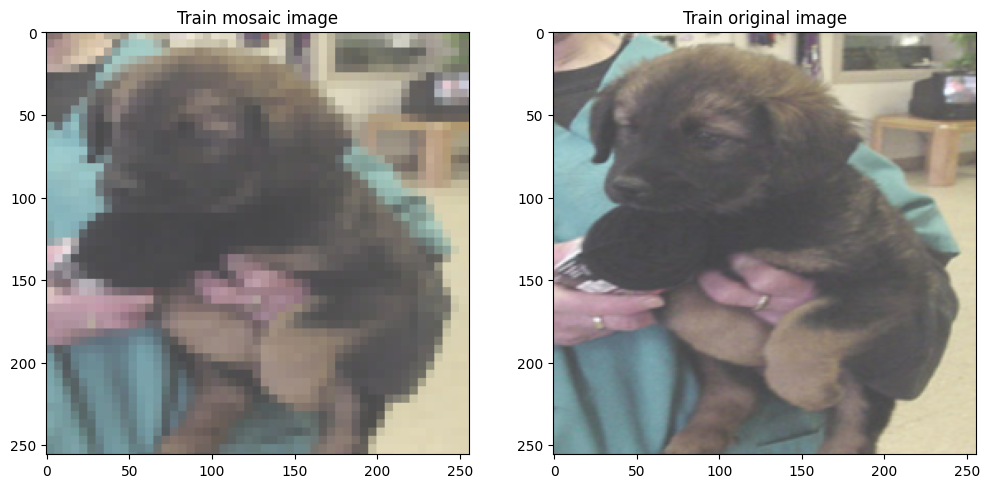

In [33]:
image_idx = np.random.randint(0, len(train_dataset))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
image = train_dataset[image_idx][0].permute(1, 2, 0)
plt.imshow(image)
plt.title("Train mosaic image")

plt.subplot(1, 2, 2)
image = train_dataset[image_idx][1].permute(1, 2, 0)
plt.imshow(image)
plt.title("Train original image")

plt.show()

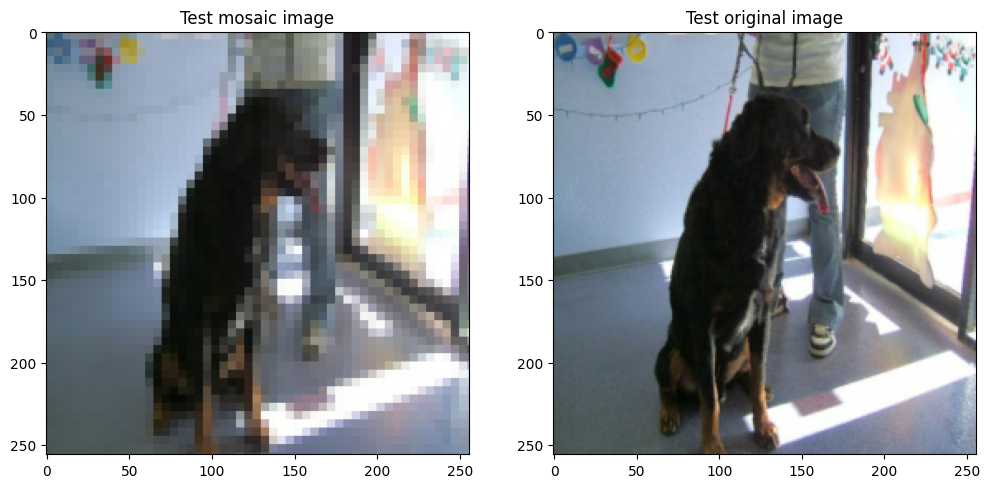

In [ ]:
image_idx = np.random.randint(0, len(test_dataset))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
m_image = test_dataset[image_idx][0].permute(1, 2, 0)
plt.imshow(m_image)
plt.title("Test mosaic image")

plt.subplot(1, 2, 2)
o_image = test_dataset[image_idx][1].permute(1, 2, 0)
plt.imshow(o_image)
plt.title("Test original image")

plt.show()

### 2. create model

use pix2pix to remove mosaic

code adapted from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/Pix2Pix

#### generator

In [34]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [43]:
x = torch.randn((1, 3, 256, 256))
model = Generator(in_channels=3, features=64)
preds = model(x)
print(preds.shape)

torch.Size([1, 3, 256, 256])


##### keras-like model summary

In [42]:
!pip install torch-summary

In [45]:
from torchsummary import summary

print(summary(model, input_data=[3, 256, 256], verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        3,136
|    └─LeakyReLU: 2-2                    [-1, 64, 128, 128]        --
├─Block: 1-2                             [-1, 128, 64, 64]         --
|    └─Sequential: 2-3                   [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 64, 64]         131,072
|    |    └─BatchNorm2d: 3-2             [-1, 128, 64, 64]         256
|    |    └─LeakyReLU: 3-3               [-1, 128, 64, 64]         --
├─Block: 1-3                             [-1, 256, 32, 32]         --
|    └─Sequential: 2-4                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-4                  [-1, 256, 32, 32]         524,288
|    |    └─BatchNorm2d: 3-5             [-1, 256, 32, 32]         512
|    |    └─LeakyReLU: 3-6               [-1, 256, 32, 32]         --


#### discriminator

In [36]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [37]:
x = torch.randn((1, 3, 256, 256))
y = torch.randn((1, 3, 256, 256))
model = Discriminator(in_channels=3)
preds = model(x, y)
print(model)
print(preds.shape)

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): Batc

#### config

In [40]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/content/dogs-vs-cats/data/train"
VAL_DIR = "/content/dogs-vs-cats/data/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

#### utils

In [41]:
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [71]:
from torchvision.utils import save_image, make_grid

def save_grid_image(batch_images, image_path):
    image_grid = make_grid(batch_images)
    save_image(image_grid, image_path)
    return image_path

### 3. train model

In [61]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [62]:
# shutil.rmtree("/content/gdrive/MyDrive/checkpoints")

In [63]:
os.mkdir("/content/gdrive/MyDrive/checkpoints")
os.mkdir("/content/gdrive/MyDrive/checkpoints/output_images")

#### 3.1 train function

In [81]:
def save_test_grid_image(generator, dataloader, epoch, batch):
  with torch.no_grad():
      for t_features, t_targets in dataloader:
        features = t_features.to(DEVICE)
        t_targets = t_targets.to(DEVICE)
        t_pred = generator(features)

        test_loss = F.mse_loss(t_pred, t_targets)
        break
      # save pred images
      pred_img_name = "pred-{}-{}.png".format(str(epoch).zfill(3), str(batch+1).zfill(5))
      save_grid_image(t_pred, f"/content/gdrive/MyDrive/checkpoints/output_images/{pred_img_name}")

      # save input images
      input_img_name = "input-{}-{}.png".format(str(epoch).zfill(3), str(batch+1).zfill(5))
      save_grid_image(features, f"/content/gdrive/MyDrive/checkpoints/output_images/{input_img_name}")

      # save real images
      real_img_name = "real-{}-{}.png".format(str(epoch).zfill(3), str(batch+1).zfill(5))
      save_grid_image(t_targets, f"/content/gdrive/MyDrive/checkpoints/output_images/{real_img_name}")

In [82]:
# save_test_grid_image(gen, test_loader, 1, 2)

In [83]:
def train_fn(epoch, disc, gen, train_loader, test_loader,
             opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):

    loop = tqdm(train_loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

        if idx % 20 == 0:
            save_test_grid_image(gen, test_loader, epoch, idx)

#### 3.2 setup and train model

In [46]:
torch.backends.cudnn.benchmark = True

In [84]:
disc = Discriminator(in_channels=3).to(DEVICE)
gen = Generator(in_channels=3, features=64).to(DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

In [50]:
if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

In [85]:
train_dataset = CustomDataSet(train_path, input_size=(256, 256), mosaic_window_size=(5, 5))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [86]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

test_dataset = CustomDataSet(test_path, input_size=(256, 256), mosaic_window_size=(5, 5))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)

In [87]:
train_fn(0, disc, gen, train_loader, test_loader,
         opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

 14%|█▍        | 173/1250 [05:24<26:58,  1.50s/it, D_fake=0.361, D_real=0.663]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 1250/1250 [38:47<00:00,  1.86s/it, D_fake=0.125, D_real=0.889]


In [97]:
cur_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
save_checkpoint(gen, opt_gen, filename=f"/content/gdrive/MyDrive/checkpoints/gen checkpoint {cur_datetime}.pth.tar")
save_checkpoint(disc, opt_disc, filename=f"/content/gdrive/MyDrive/checkpoints/disc checkpoint {cur_datetime}.pth.tar")

=> Saving checkpoint
=> Saving checkpoint


In [94]:
from datetime import datetime

datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2023-10-08 13:20:17'